In [1]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
import clmm
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
clmm.__version__

'1.10.0'

In [3]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [4]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)# c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

## Hyper-parameters (non-cosmo)

In [5]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.3), .5
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [6]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(12, 15., 50)
z_grid = np.linspace(.1, 1, 10)

In [7]:
np.log10(2*1e15)

15.301029995663981

# Cluster Abundance

In [8]:
z_edges = np.linspace(0.2, 1, 4)
Z_bin = binning(z_edges)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 5))
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [12]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation': 'Duffy08'}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega_log_slope':True,
           'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':True, 'compute_halo_bias':True ,'compute_purity':True }

In [13]:
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

CPU times: user 20.7 ms, sys: 4.93 ms, total: 25.6 ms
Wall time: 25.2 ms


In [14]:
#define integrand
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [15]:
Omega = (4*np.pi)
N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [16]:
adds1 = {'add_purity' : False, 'add_completeness':False}
adds2 = {'add_purity' : True, 'add_completeness':False}
adds3 = {'add_purity' : False, 'add_completeness':True}
adds4 = {'add_purity' : True, 'add_completeness':True}
adds_list = [adds1, adds2, adds3, adds4]
list_dNdlambda = []
for adds in adds_list:
    integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)
    list_dNdlambda.append(simps(integrand_count, logm_grid, axis=1))

# Lensing profiles

In [17]:
cosmo_clmm.get_rho_c(.1)

152241922857.01013

In [18]:
r = np.logspace(np.log10(.01), np.log10(20),30)
cluster_lensing_1h_mis_mp = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                  two_halo=False, boost_factor=False, miscentering=True, multiprocessing=True, fmis=0.11, Rmis=.15)

You have 16 CPUs


# progress ...: 100%|██████████| 500/500 [00:04<00:00, 123.00it/s]


In [19]:

cluster_lensing_1h_boost = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                  two_halo=False, boost_factor=True, miscentering=False, multiprocessing=True, fmis=0.11, Rmis=.15)

In [20]:
cluster_lensing_1h = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                  two_halo=False, boost_factor=False, miscentering=False, multiprocessing=True)

In [25]:
cluster_lensing_all = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                  two_halo=True, boost_factor=False, 
                                                                             miscentering=False, 
                                                                             multiprocessing=True, 
                                                                             return_two_halo_term=False)

In [26]:
NDS_profiles_mis = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_1h_mis_mp, lensing_radius = r, grids = grids)
DS_profiles_mis = NDS_profiles_mis/N
#
NDS_profiles_boost = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing =cluster_lensing_1h_boost, lensing_radius = r, grids = grids)
DS_profiles_boost = NDS_profiles_boost/N
#
NDS_profiles_1h = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_1h, lensing_radius = r, grids = grids)
DS_profiles_1h = NDS_profiles_1h/N
#
NDS_profiles_all = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_all, lensing_radius = r, grids = grids)
DS_profiles_all = NDS_profiles_all/N
#
#NDS_profiles_2h = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_2h, lensing_radius = r, grids = grids)
#DS_profiles_2h = NDS_profiles_2h/N

Text(0.5, 0, '$R [Mpc]$')

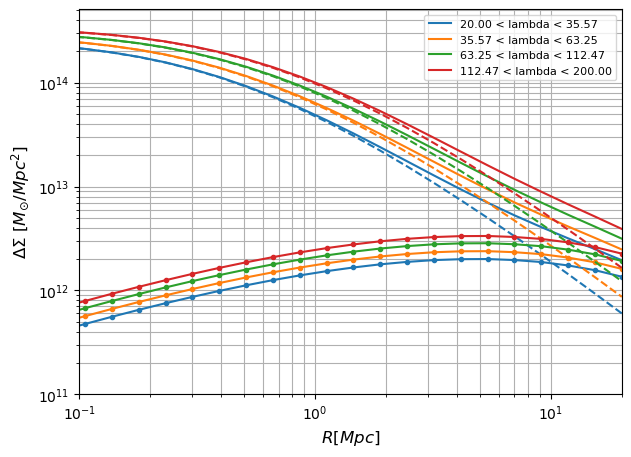

In [27]:
plt.figure(figsize=(7,5))
for j in range(len(Richness_bin)):
    for i in range(len(Z_bin)):
        if i==2: 
            plt.plot([], [], '-',color= 'C'+str(j), label = f'{Richness_bin[j][0]:.2f} < lambda < {Richness_bin[j][1]:.2f}')
            plt.loglog(r, DS_profiles_all[:,j,i], '-',  color= 'C'+str(j))
            plt.loglog(r, DS_profiles_1h[:,j,i], '--',  color= 'C'+str(j))
            plt.loglog(r, DS_profiles_2h[:,j,i], '.-',  color= 'C'+str(j))
       
plt.xscale('log')
plt.xlim(.1, 20)
plt.ylim(1e11)
plt.grid(which='both')
plt.legend(ncols=1, fontsize=8)
plt.ylabel(r'$\Delta\Sigma\ [M_{\odot}/Mpc^2]$', fontsize=12)
plt.xlabel(r'$R [Mpc]$', fontsize=12)

Text(0.5, 0, '$R [Mpc]$')

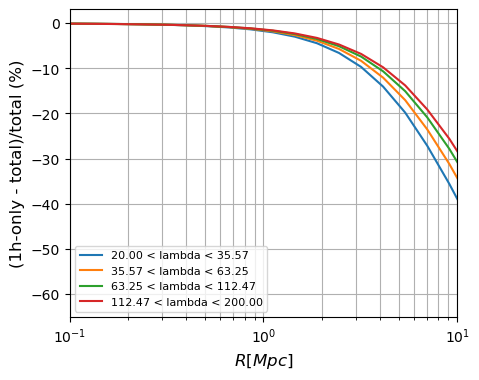

In [28]:
plt.figure(figsize=(5,4))
for j in range(len(Richness_bin)):
    for i in range(len(Z_bin)):
        if i==0: plt.plot([], [], '-',color= 'C'+str(j), label = f'{Richness_bin[j][0]:.2f} < lambda < {Richness_bin[j][1]:.2f}')
        plt.plot(r, 100*(DS_profiles_1h[:,j,i]-DS_profiles_all[:,j,i])/DS_profiles_all[:,j,i], '-',  color= 'C'+str(j))
        break
plt.xscale('log')
plt.xlim(.1, 10)
plt.grid(which='both')
plt.legend(ncols=1, fontsize=8)
plt.ylabel(r'(1h-only - total)/total (%)', fontsize=12)
plt.xlabel(r'$R [Mpc]$', fontsize=12)

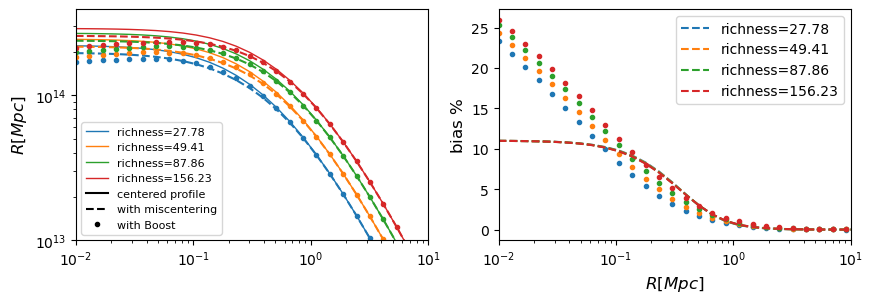

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
for i in range(len(Z_bin)):
    for j in range(len(Richness_bin)):
        plt.loglog(r, DS_profiles_1h[:,j,i], lw=1, label =f'richness={np.mean(Richness_bin[j]):.2f}',color= 'C'+str(j))
        plt.loglog(r, DS_profiles_mis[:,j,i], '--', color= 'C'+str(j))
        plt.loglog(r, DS_profiles_boost[:,j,i], '.',  color= 'C'+str(j))
    break
plt.plot([], [], '-k', label = 'centered profile')
plt.plot([], [], '--k', label = 'with miscentering')
plt.plot([], [], '.k', label = 'with Boost')
plt.xscale('log')
plt.xlim(0.01, 10)
plt.ylim(1e13)
plt.legend(ncols=1, fontsize=8)
plt.ylabel(r'$\Delta\Sigma\ [M_{\odot}/Mpc^2]$', fontsize=12)
plt.ylabel(r'$R [Mpc]$', fontsize=12)
plt.subplot(122)
for i in range(len(Z_bin)):
    for j in range(len(Richness_bin)):
        plt.plot(r, 100*(DS_profiles_1h[:,j,i]-DS_profiles_mis[:,j,i])/DS_profiles_1h[:,j,i], '--',label =f'richness={np.mean(Richness_bin[j]):.2f}',color= 'C'+str(j))
        plt.plot(r, 100*(DS_profiles_1h[:,j,i]-DS_profiles_boost[:,j,i])/DS_profiles_1h[:,j,i], '.', color= 'C'+str(j))
        #plt.loglog(r, DS_profiles_boost[:,j,i], '.',  color= 'C'+str(j))
    break
plt.xscale('log')
plt.xlim(0.01, 10)
plt.ylabel(r'bias $\%$', fontsize=12)
plt.xlabel(r'$R [Mpc]$', fontsize=12)
#plt.ylim(1e13)
plt.legend()